# Concatenate surface tracers with Dask

***

In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt, patches
from datetime import datetime, timedelta
from dask.diagnostics import ProgressBar
from contextlib import ExitStack
from glob import glob
from salishsea_tools import nc_tools, grid_tools, places

%matplotlib inline

In [2]:
plt.rcParams['font.size'] = 12

***

### Extraction

Define parameters

In [3]:
timerange = [datetime(2014, 12, 1, 0, 0), datetime(2020, 2, 1, 23, 59)]
subdomains = {'NEMO': [110, 370, 300, 850], 'GEM': [95, 175, 90, 220]}
datapath = '/ocean/bmoorema/research/MEOPAR/analysis-ben/data'

Define NEMO concatenation routine

In [4]:
def concatenate_NEMO(
    variable, timerange, subdomain, num_workers=8, version='201905',
    datapath='/ocean/bmoorema/research/MEOPAR/analysis-ben/data',
):
    """
    """
    
    # Define xarray load/save parameters
    chunks = {'time_counter': 24, 'deptht': 1, 'y': 898, 'x': 398}
    slc = {'deptht': 0, 'y': slice(*subdomain[2:]), 'x': slice(*subdomain[:2])}
    timestr = '_'.join(t.strftime('%Y%m%d') for t in timerange)
    drop_vars = [
        'axis_nbounds', 'nvertex', 'nav_lat', 'nav_lon', 'area',
        'bounds_lon', 'bounds_lat', 'deptht_bounds',
        'time_centered', 'time_centered_bounds', 'time_counter_bounds',
        'ammonium', 'silicon', 'diatoms', 'flagellates', 'ciliates',
        'microzooplankton', 'dissolved_organic_nitrogen',
        'particulate_organic_nitrogen', 'biogenic_silicon',
        'mesozooplankton', 'sossheig', 'vosaline',
    ]
    
    # Interpret filetype from variable name
    if variable == 'votemper':
        filetype = 'grid_T'
    elif variable == 'nitrate':
        filetype = 'ptrc_T'
    else:
        raise ValueError(f'Unrecognized variable name: {variable}')
    
    # Build file list
    files = [
        nc_tools.get_hindcast_prefix(timerange[0] + timedelta(days=d), version=version) + f'_{filetype}.nc'
        for d in range(np.diff(timerange)[0].days + 1)
    ]

    # Load, slice and save results record for each file type
    with xr.open_mfdataset(files, chunks=chunks, drop_variables=drop_vars) as ds:
        with ProgressBar():
            data = ds.isel(slc).drop_vars('deptht').load(scheduler="processes", num_workers=num_workers)
    data.to_netcdf(f'{datapath}/SalishSea_1h_{timestr}_{variable}.nc')


def merge_NEMO(files):
    """
    """
    
    # Parse filenames
    variables = []
    for file in files:
        filestrings = file[:-3].split('_')
        variables.append(filestrings[-1])
        prefix = '_'.join(filestrings[:-1])
    
    # Merge variables and save to compressed netCDF file
    encoding = {var: {'zlib': True} for var in variables}
    with ExitStack() as stack:
        ds = [stack.enter_context(xr.open_dataset(file)) for file in files]
        xr.merge(ds, combine_attrs='override').to_netcdf(prefix + '_grid_T.nc', encoding=encoding)

Concatenate temperature record and save to temporary uncompressed netCDF

In [ ]:
# Load temperature record
concatenate_NEMO('votemper', timerange, subdomains['NEMO'], datapath=datapath)

Concatenate nitrate record and save to temporary uncompressed netCDF

In [ ]:
# Load nitrate record
concatenate_NEMO('nitrate', timerange, subdomains['NEMO'], datapath=datapath)

Merge concatenated NEMO datasets and save to compressed netCDF

In [45]:
# Merge variables and save to compressed netCDF file
timestr = '_'.join(t.strftime('%Y%m%d') for t in timerange)
merge_NEMO(glob(f'{datapath}/SalishSea_1h_{timestr}*'))

***

### HRDPS

In [4]:
# Parameters
url = 'https://salishsea.eos.ubc.ca/erddap/griddap/'
slc = {'gridY': slice(*subdomains['GEM'][2:]), 'gridX': slice(*subdomains['GEM'][:2])}
drop_vars = ['atmpres', 'precip', 'qair', 'solar', 'tair', 'therm_rad']

# Build HRDPS mask
tmask = xr.open_dataset(f'{url}/ubcSSn3DMeshMaskV17-02').tmask[0, 0, ...]
grid_NEMO = xr.open_dataset(f'{url}/ubcSSnBathymetryV17-02')
grid_GEM = xr.open_dataset(f'{url}/ubcSSaAtmosphereGridV1').isel(slc)
mask = grid_tools.build_GEM_mask(grid_GEM, grid_NEMO, tmask)
grid_GEM.update({'longitude': grid_GEM.longitude - 360})

# Load HRDPS record from erddap
with xr.open_dataset(url + 'ubcSSaSurfaceAtmosphereFieldsV1', drop_variables=drop_vars) as ds:
    data = ds.sel(time=slice(*timerange)).isel(slc).load()

# Combine dataset
data = xr.merge([data, grid_GEM], combine_attrs='override').assign({'landmask': (['gridY', 'gridX'], mask)})

# Save to compressed netCDF
timestr = '_'.join(t.strftime('%Y%m%d') for t in timerange)
encoding = {var: {'zlib': True} for var in ('u_wind', 'v_wind')}
data.to_netcdf(f'{datapath}/HRDPS_1h_{timestr}_wind.nc', encoding=encoding)

Building HRDPS mask: 100%|██████████| 10400/10400 [04:02<00:00, 42.97it/s]


<xarray.Dataset>
Dimensions:    (gridX: 80, gridY: 130)
Coordinates:
  * gridY      (gridY) float64 2.25e+05 2.275e+05 2.3e+05 ... 5.45e+05 5.475e+05
  * gridX      (gridX) float64 2.375e+05 2.4e+05 ... 4.325e+05 4.35e+05
Data variables:
    longitude  (gridY, gridX) float32 -124.8 -124.7 -124.7 ... -123.1 -123.0
    latitude   (gridY, gridX) float32 47.93 47.94 47.94 ... 50.93 50.93 50.94
Attributes:
    acknowledgement:           Environment Canada, MEOPAR, ONC, Compute Canada
    cdm_data_type:             Grid
    Conventions:               CF-1.6, COARDS, ACDD-1.3
    coverage_content_type:     modelResult
    creator_email:             sallen@eos.ubc.ca
    creator_name:              Salish Sea MEOPAR Project Contributors
    creator_url:               https://salishsea-meopar-docs.readthedocs.io/
    drawLandMask:              over
    GRIB2_grid_template:       20
    history:                   Mon Mar  7 10:07:34 2016: ncks -4 -L4 -O /resu...
    infoUrl:                   https://salishsea-meopar-docs.readthedocs.io/e...
    institution:               UBC EOAS
    institution_fullname:      Earth, Ocean & Atmospheric Sciences, Universit...
    keywords:                  atmosphere, HRDPS, latitude, longitude, model ...
    keywords_vocabulary:       GCMD Science Keywords
    license:                   The Salish Sea MEOPAR NEMO model results are c...
    NCO:                       4.4.2
    project:                   Salish Sea MEOPAR NEMO Model
    sourceUrl:                 (local files)
    standard_name_vocabulary:  CF Standard Name Table v29
    summary:                   HRDPS, Salish Sea, Atmospheric Forcing Grid, G...
    title:                     HRDPS, Salish Sea, Atmospheric Forcing Grid, G...

***

### Plotting section ...

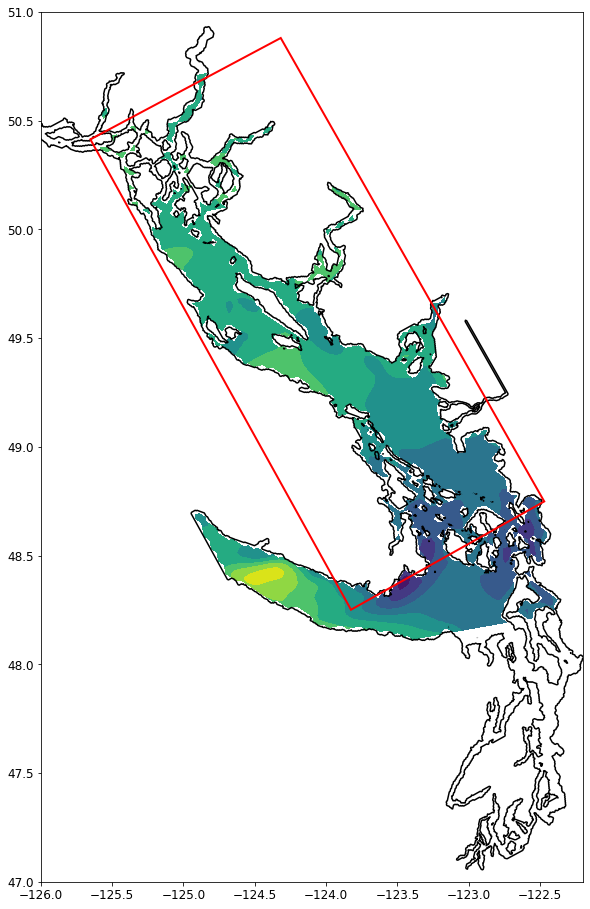

In [5]:
# Load grid variables
coords = xr.open_dataset('/data/bmoorema/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc', decode_times=False)
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
lon, lat = [coords[key][0, ...].values for key in ['glamt', 'gphit']]
tmask = mask.tmask[0, 0, ...].values

# Make plot area
fig, ax = plt.subplots(figsize=(10, 16))
ax.set_xlim([-126, -122.2])
ax.set_ylim([47, 51])
ax.set_aspect(1/np.cos(np.deg2rad(49)))

# Plot NEMO mask and subdomain
ax.contour(lon, lat, tmask, levels=[-0.01, 0.01], colors='k', zorder=1)
bounds, indices = np.array(subdomains['NEMO']), [[2, 0], [2, 1], [3, 1], [3, 0], [2, 0]]
corners = np.array([(lon[tuple(bounds[yx])], lat[tuple(bounds[yx])]) for yx in indices])
ax.add_patch(patches.Polygon(corners, fill=False, color='r', linewidth=2))

# Plot wind field
with xr.open_dataset(f'{datapath}/HRDPS_1h_20141201_20200201_wind.nc') as ds:
    ax.contourf(ds.longitude, ds.latitude, np.ma.masked_where(ds.landmask == 0, ds.v_wind[0, ...]), zorder=0)

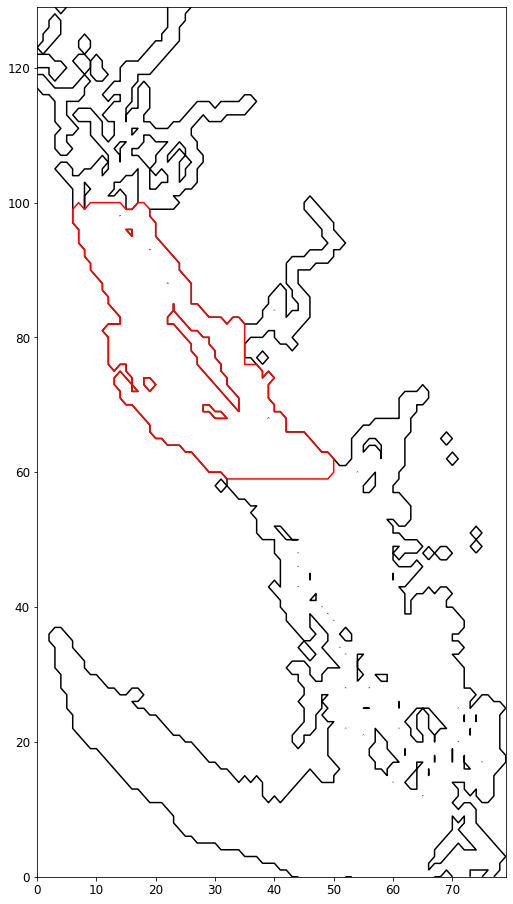

In [35]:
fig, ax = plt.subplots(figsize=(10, 16))
ax.set_aspect(5/4.4)

# Meshmask cut off inlets and JdF
with xr.open_dataset(f'{datapath}/HRDPS_1h_20141201_20200201_wind.nc') as ds:
    mask = ds.landmask.values
    ax.contour(mask, levels=[-0.01, 0.01], colors='k')
    mask[:60, :] = 0   # San Juan Islands
    mask[100:, :] = 0  # Discovery Islands
    mask[:, 50:] = 0 # Howe Sound
    mask[76:, 35:] = 0 # Jervis Inlet
    ax.contour(mask, levels=[-0.01, 0.01], colors='r')
    mask = mask.reshape(-1).astype('bool')